# Computer Vision Project 

## Code author: Brewton LOPES MORAIS
## Date: 04 May 2022.

# Folder requirement 
 The figs_folder variable is a variable containing the name of the folder you're going to save the 16x16 images. Therefore, before running the code, create a folder with name 'images', or any name you may prefer. Also, create a folder named "images224" (necessary in the 4th cell) for the 224x224 hand figures or any other name you may prefer (attention to update it in the fourth cell in case you want to change the name). 

## Cell 1: Import modules 

In [1]:
import numpy as np
from PIL import Image
import io #module for dealing with several types of I/O
import cv2  #Open CV Library
import time 
from datetime import timedelta
import ipywidgets as widgets
import matplotlib.pyplot as plt
import argparse
import sys
import os
from matplotlib import image as im
import pandas as pd
import random

figs_folder='images'

## Cell 2: it contains all the functions necessary for the algorithm and for the stocking process. 

In [2]:
# Function for detecting objects of different sizes based on the input image using the Cascade Method
def detect(img, cascade):
    # The detected objects are returned as a list of rectangles
    # as we update the scale factor by a small factor (0.1~0.2), we can see how time improvement is updated
    rects = cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=4, minSize=(30, 30),
                                     flags=cv2.CASCADE_SCALE_IMAGE) #flags parameter has the same meaning for an old cascade
    
    if len(rects) == 0:
        return []
    rects[:,2:] += rects[:,:2]
    return rects.tolist()

# Drawn rectangles over the image for recongnition 
def draw_rects(img, rects, color):
    #(x1, y1) are starting coordinates of rectangle; (x2, y2) are ending coordinates
    for x1, y1, x2, y2 in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

# Counter for letters inside figs_folder
def count_letter(letter):
    l = 0
    letter
    for fig in os.listdir(figs_folder):
        if letter in fig:
            l+=1
    return l

## Once you run the third (below) cell, you are going to give the program 3 inputs.
1. "Insert the letter (uppercase): " Here you tell the program which letter you are going to make with your hand. Example: if you want to make it A, type A and hit Enter.
2. "Insert the maximum number of pictures you want to stock: " Here you tell how many of the chosen letter you want to stock. For example, 10.
3. "Last image counter: " I strongly recommend you to put it always 0.

About the third input: Here, the last image counter corresponds to last image of a given letter you've saved. It is highly recommended that you run program like the following:
You save all the A's you want, and only then you change it to another letter, B, for example. Like that, you can always put 0 in the last input.


## Order of cell running :

    After you have runned the two cells above, you must follow the given order: 
1. Run cell 3 -> It saves all the images you want. 
2. Run cell 4 -> It creates/updates dataset.txt. 

    Now, I assumed you are going to do it again but for other letter.
3. Run cell 3 again -> The same as previous, but with a new letter. 
4. Run cell 4 again -> The same as previous, but with a new letter. 

5. After saving the data set you want, for exemple: 100 letter for A, B and C, you may verify it on you dataset.txt and on the images folders 'images' and 'images224'. 

## Cell 3: Local version for Face Detection and CamShift algorithm. 

As you save your images, you can monitor how your face and you hand are being detected on the poped ups windows. Make sure your hand is being well detected by the gray window, avoid letting your head to close of your hand.  

In [3]:
currentLetter = input("Insert the letter (uppercase): ")
maximg_counter = int(input("Insert the maximum number of pictres you want to stock: "))
last_image_counter = int(input("Last image counter: "))

img_counter = last_image_counter

cascade = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml") # face detection

cap = cv2.VideoCapture(0)

margin = 20 # margin for the rectangle drawn 

track_window = []    # Empty list to stock the rectangle coordinates

while len(track_window)==0: # Loop stops as soon as a face is detected

    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break
        
    vis = frame.copy()
    
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    
    track_window = detect(gray, cascade) # Empty when there's no face in front of cam
    print(track_window, type(track_window))
    
    draw_rects(vis, track_window, (0, 255, 0))
    
    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
        
# After  track window detection, select the coordinates of the first face detected 
x0, y0, x1, y1 = track_window[0]

hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
hsv_roi = hsv[y0:y1, x0:x1] # hsv acting over region of interest (track_window) 
mask_roi = mask[y0:y1, x0:x1] # mask acting over region of interest (track_window) 


hist = cv2.calcHist( [hsv_roi], [0], mask_roi, [16], [0, 180] )
cv2.normalize(hist, hist, 0, 255, cv2.NORM_MINMAX)

# Stop criteria
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
print(term_crit)

im_w = vis.shape[1] # Image width 
im_h = vis.shape[0] # Image heigth 
      
track_window_hand = (0, 0, im_h, im_w)

while True: 
    # Create new frame for CamShift to detect the hand
    ret2, frame2 = cap.read()
    if not ret2:
        print("Failed to grab frame in second while")
        break
    
    vis2 = frame2.copy()
    
    hsv2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
    mask2 = cv2.inRange(hsv2, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
    
    # Probability calculation based on the histogram computed for the face
    prob = cv2.calcBackProject([hsv2], [0], hist, [0, 180], 1)
    prob &= mask2

    # Cunning to avoid wrong type in track_window 
    a, b, c, d = track_window[0]
    var = a, b, c, d
    rect, track_window_cs = cv2.CamShift(prob, var, term_crit)
    x, y, w, h = track_window_cs # Here, track_window is a tuple, since it's an output of CamShift
        
    # At this point, I've got my face being erased
    frame_cs = cv2.rectangle(frame2, (x, y), (x+w, y+h), 255, 2)
    cv2.imshow('Test Camshift', frame2)
    
    prob[y:y+h,x:x+w] = 0 # Erase face probability  

    save_prob = prob.copy()
    
    # Add another camshift here to detect hand
    
    rect_hand, track_window_hand = cv2.CamShift(prob, track_window_hand, term_crit)
    xh, yh, wh, hh = track_window_hand
    
    # The hand image is sucessfully being detected, however the user must
    # be well positioned, i.e, positioning their head away from hand and 
    # they must be in a well lightned place 
    
    img_hand = cv2.rectangle(prob, (xh,yh), (xh+wh, yh+hh), 255, 2)
    cv2.imshow('Test hand', img_hand)

    # Here I use the frame save_prob to avoid drawning a rectangle on the output image (the same images we're going to store)
    selectedHand =  save_prob[yh-margin:yh+hh+margin, xh-margin:xh+wh+margin+(hh-wh)] # with margin and delta_x = (hh-wh) to make it a square
    
    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
        
    elif k%256 == 32:
        # SPACE pressed : the program saves the images (16x16, 224x224)
        
        img_name1 = f"{currentLetter}_{img_counter}_16.jpg" # currentLetter being the letter theat the user passed as input to save
        img_name2 = f"{currentLetter}_{img_counter}_224.jpg"
        
        # Resizing of images 
        square16 = cv2.resize(selectedHand, dsize=(16,16), interpolation=cv2.INTER_CUBIC ) # resize to 16x16
        square224 = cv2.resize(selectedHand, dsize=(224,224), interpolation=cv2.INTER_CUBIC ) # resize to 224x224
        
        # Storing the 16x16 images to figs_folder
        cv2.imwrite(os.path.join(figs_folder, img_name1), square16)
        
        # Storing the 224x224 images to folder named "images224"
        cv2.imwrite(os.path.join("images224", img_name2), square224)
        
        # Print to allow the user to monitor how many images they have saved until current instant
        print(f"snapshot {img_counter} saved to: {img_name1}")
        
        # As soon as the img_counter reaches the maximum number specified by the user, program stops automatically
        
        img_counter += 1
        if(img_counter == maximg_counter+last_image_counter):
            print(f"{maximg_counter} images were saved of letter {currentLetter}.")
            break

cap.release()
cv2.destroyAllWindows()
    

Insert the letter (uppercase):  A
Insert the maximum number of pictres you want to stock:  10
Last image counter:  0


[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[] <class 'list'>
[[260, 141, 406, 287]] <class 'list'>
(3, 10, 1)
Escape hit, closing...


## Cell 4: Data set creation.

The cell below creates the dataset.txt according to the images saved on the previous cell. The user must pay attention: if this cell is runned twice after running the previous, it's going to duplicate the data set. 

In [31]:
# Folder name that is in the same folder as the notebook
print('Loading figures from the following path:\n')
print(os.path.abspath(figs_folder))
print('\Listing ...', len(os.listdir(figs_folder)),' figures')
print(os.listdir(figs_folder))

print('\Reading and storing letters, vector in dataset')

# Create empty lists to store the figures and its labels 
figs16 = []
labels16= []
figs224 = []
labels224 = []

for i in range(last_image_counter, count_letter(currentLetter)):

    fig = f"{currentLetter}_{i}_16.jpg"
    sample16 = im.imread(os.path.join(figs_folder,fig)).ravel()
    figs16.insert(len(figs16), sample16)
    labels16.append(fig[0])

## In case the user also wants to create a data set for the 224x224 images, uncomment the following lines (23 to 26)

#     elif '224' in fig:
#         sample224 = im.imread(os.path.join(figs_folder,fig)).ravel()
#         figs224.insert(len(figs16), sample224)
#         labels224.append(fig[0])

figs16 = np.array(figs16)
figs224 = np.array(figs224)
print('After stocking', figs16.shape, figs224.shape) 


print('\nSaving data to text file: dataset.txt')
# if file does not exist write header 
if not os.path.isfile('dataset.txt'):
    pd.DataFrame(figs16, index=labels16).to_csv('dataset.txt', header=False)
else: # else it exists so append without writing the header
    pd.DataFrame(figs16, index=labels16).to_csv('dataset.txt', mode = 'a', header=False)
    
#pd.DataFrame(figs16, index=labels16).to_csv('dataset.txt', header=False)
#pd.DataFrame(figs224, index=labels224).to_csv('dataset_224.txt', header=False)
print('\nDone.')

lines = open('dataset.txt').readlines()
random.shuffle(lines)
open('dataset.txt', 'w').writelines(lines)


Loading figures from the following path:

C:\Users\brewt\computer_vision\images
\Listing ... 300  figures
['Q_0_16.jpg', 'Q_10_16.jpg', 'Q_11_16.jpg', 'Q_12_16.jpg', 'Q_13_16.jpg', 'Q_14_16.jpg', 'Q_15_16.jpg', 'Q_16_16.jpg', 'Q_17_16.jpg', 'Q_18_16.jpg', 'Q_19_16.jpg', 'Q_1_16.jpg', 'Q_20_16.jpg', 'Q_21_16.jpg', 'Q_22_16.jpg', 'Q_23_16.jpg', 'Q_24_16.jpg', 'Q_25_16.jpg', 'Q_26_16.jpg', 'Q_27_16.jpg', 'Q_28_16.jpg', 'Q_29_16.jpg', 'Q_2_16.jpg', 'Q_30_16.jpg', 'Q_31_16.jpg', 'Q_32_16.jpg', 'Q_33_16.jpg', 'Q_34_16.jpg', 'Q_35_16.jpg', 'Q_36_16.jpg', 'Q_37_16.jpg', 'Q_38_16.jpg', 'Q_39_16.jpg', 'Q_3_16.jpg', 'Q_40_16.jpg', 'Q_41_16.jpg', 'Q_42_16.jpg', 'Q_43_16.jpg', 'Q_44_16.jpg', 'Q_45_16.jpg', 'Q_46_16.jpg', 'Q_47_16.jpg', 'Q_48_16.jpg', 'Q_49_16.jpg', 'Q_4_16.jpg', 'Q_50_16.jpg', 'Q_51_16.jpg', 'Q_52_16.jpg', 'Q_53_16.jpg', 'Q_54_16.jpg', 'Q_55_16.jpg', 'Q_56_16.jpg', 'Q_57_16.jpg', 'Q_58_16.jpg', 'Q_59_16.jpg', 'Q_5_16.jpg', 'Q_60_16.jpg', 'Q_61_16.jpg', 'Q_62_16.jpg', 'Q_63_16.jpg',

## Cell 5: In case you want to check how your figure looks like as a matrix, and as a gray image with 16x16 pixels.

EXEMPLE
Reading letter R as a matrix.
[[  0   3   2 148 157   1   0   1   0   0   0   0   0   0   0   0]
 [  0   0   0 203 158   2   0   0   0   0   0   0   0   0   0   0]
 [  3   0   3   0 160   0   5   0   0   0   0   0   0   0   0   0]
 [  0   0   0 243 158 156   0   2   0   0   0   0   0   0   0   0]
 [  1   2 255 156 255 253   6   1   0   0   0   0   0   0   0   0]
 [  2   0 254 156 157 255 255   0   0   0   0   0   0   0   0   0]
 [  0   1 154 253 157 255 242   1   0   0   0   0   0   0   0   0]
 [  0   0 254 255 159 250 255   0   0   0   0   0   0   0   0   0]
 [  0   0 255 252 152 255 253   1   0   0   0   0   0   0   0   0]
 [  1   0 255 255 254 254 255   0   0   0   0   0   0   0   0   0]
 [  1   3   0 255 255 255  26   0   0   0   0   0   0   0   0   0]
 [  0   2   0 255 205 253  25   3   0   0   0   0   0   0   0   0]
 [  0   2   1 252 255 255 253   0   0   0   0   0   0   0   0   0]
 [  3   0   0 247 137 254   0   2   0   0   0   0   0   0   0   0]
 [  0   1   0  89   3   

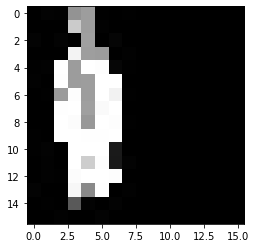

In [5]:
print('EXEMPLE')
file_row = 2 # Change the value in case you want to read another line

letter = pd.read_csv('dataset.txt', header=None).iloc[file_row,0]
letter_vector= np.array([int(x) for x in pd.read_csv('dataset.txt', header=None).iloc[file_row,1:].values])
print('Reading letter', letter, 'as a matrix.')
letter_matrix = letter_vector.reshape(16,16)
print(letter_matrix)
plt.figure()
plt.imshow(letter_matrix, cmap='gray')
plt.show()

# Note: if after all this you're having problems to understand how the code runs, I can send you a short video (less than 4 minutes) that I have already created to show you how it works.  